In [13]:
%matplotlib widget

from os import path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from qcnico.coords_io import read_xsf
from qcnico.qcplots import plot_MO
from remove_dangling_carbons import remove_dangling_carbons

def gen_mos(Mdir,lbls,filename_template='MOs_ARPACK_bigMAC'):
    for nn in lbls:
        yield np.load(Mdir+f'/{filename_template}-{nn}.npy')

def gen_energies(edir,lbls,filename_template='eARPACK_bigMAC'):
    for nn in lbls:
        yield np.load(edir+f'/{filename_template}-{nn}.npy')


def gen_pos(posdir, lbls, rCC):
    for nn in lbls:
        yield remove_dangling_carbons(read_xsf(path.join(posdir,f"bigMAC-{nn}_relaxed.xsf"))[0], rCC)



rCC = 1.8

datadir = path.expanduser("~/Desktop/simulation_outputs/percolation/40x40")
posdir = path.join(datadir, "structures")
edir = path.join(datadir, 'eARPACK')
Mdir = path.join(datadir,'MOs_ARPACK')

edir_occ = path.join(edir, 'occupied_cleaned')
edir_vir = path.join(edir, 'virtual_cleaned')

Mdir_occ = path.join(Mdir, 'occupied_cleaned')
Mdir_vir = path.join(Mdir, 'virtual_cleaned')

evenN_lbls = np.load('evenN_lbls.npy')


# eoccs = energies_arpack(edir_occ, evenN_lbls)
# Moccs = mos_arpack(Mdir_occ, evenN_lbls)

# evirs = energies_arpack(edir_vir, evenN_lbls)
# Mvirs = mos_arpack(Mdir_vir, evenN_lbls)

check_pos = gen_pos(posdir, evenN_lbls, rCC)

In [28]:
boys_dir = '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/'
boys_files = glob(boys_dir + '*npy')
print(boys_files)
lbls_boys = np.array([int(f.split('-')[1].split('.')[0]) for f in boys_files])

sb = set(lbls_boys)
sn = set(evenN_lbls)

boys_lbls = list(sn & sb) # keep only boys MOs of structures with even Natoms
print(boys_lbls)
n_boys_lbls = len(boys_lbls)

edir_vir_og = path.join(edir, 'virtual')
Mdir_vir_og = path.join(Mdir, 'virtual')

evir_ARPACK = gen_energies(edir_vir_og,boys_lbls)
Mvir_ARPACK = gen_mos(Mdir_vir_og,boys_lbls)

Mvir_boys = gen_mos(boys_dir,boys_lbls,filename_template='boyz_MOs_bigMAC')

diffs = np.ones((n_boys_lbls,200)) * -1
max_orth_diff = np.ones(n_boys_lbls) * -1

for k, Ma, Mb in zip(range(n_boys_lbls), Mvir_ARPACK, Mvir_boys):
    nmos_arpack =  Ma.shape[1]
    nmos_boys =  Mb.shape[1]
    assert nmos_arpack == nmos_boys

    diffs[k,:nmos_arpack] = np.linalg.norm(Ma - Mb,axis=0)
    max_orth_diff[k] = np.max(np.abs(np.eye(nmos_boys) - (Mb.T @ Mb)))



print(np.max(diffs[diffs >= 0]))
print(np.mean(diffs[diffs >= 0]))
print(np.min(diffs[diffs >= 0]))

['/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-14.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-28.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-29.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-15.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-9.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-17.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-16.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-12.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-13.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/vir

Check if Boys MOs are orthogonal to each other

In [21]:
plt.imshow(Mb.T @ Mb)
print('Max deviation from orthogonality = ', np.max(max_orth_diff))

Max deviation from orthogonality =  7.114309141798003e-13


Let's plot the Boys MO which is most different from its corresponding ARPACK MO

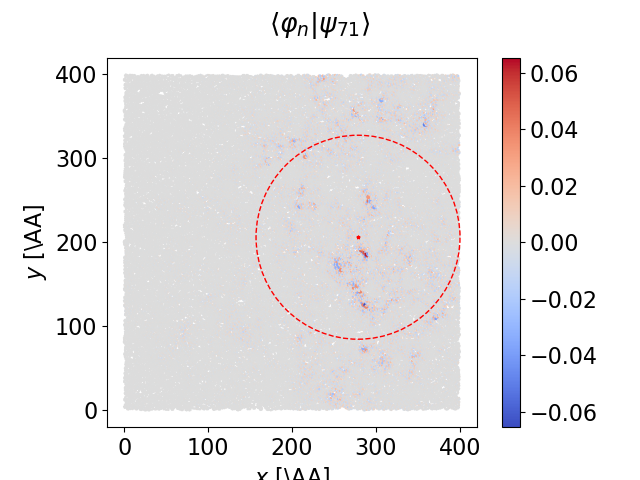

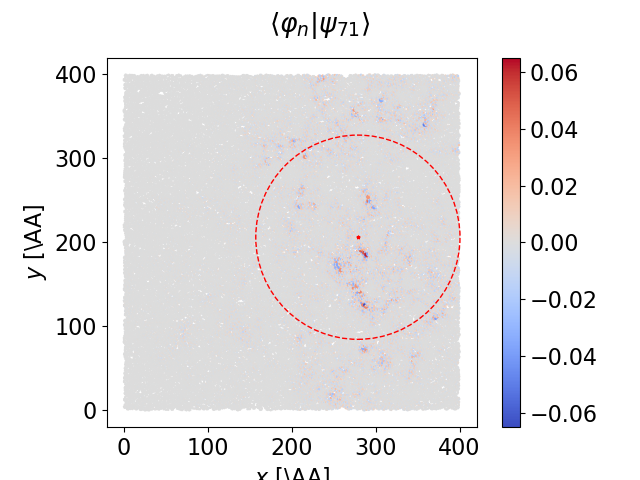

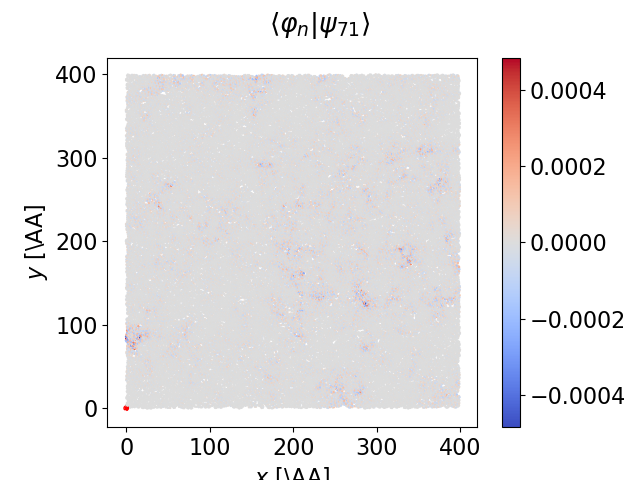

In [27]:
from qcnico.qcplots import plot_MO

ilbl, iMO = np.unravel_index(np.argmax(diffs),diffs.shape)
nn = boys_lbls[ilbl]

pos = remove_dangling_carbons(read_xsf(path.join(posdir,f"bigMAC-{nn}_relaxed.xsf"))[0], rCC)
Marpack = np.load(path.join(Mdir_vir_og, f'MOs_ARPACK_bigMAC-{nn}.npy'))
Mboys = np.load(path.join(boys_dir, f'boyz_MOs_bigMAC-{nn}.npy'))

Mdiff = Marpack - Mboys

plot_MO(pos,Marpack,iMO, dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,usetex=False,plot_amplitude=True,cmap='coolwarm')
plot_MO(pos,Mboys,iMO, dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,usetex=False,plot_amplitude=True,cmap='coolwarm')
plot_MO(pos,Mdiff,iMO, dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,usetex=False,plot_amplitude=True,cmap='coolwarm')
